In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
def load_embeddings(path, pad_token='PAD', unk_token='UNK', num_tokens=100_000, verbose=True):
    
    vocab = dict()
    embeddings = list()
    
    with open(path, encoding='utf-8') as file:
        vocab_size, embedding_dim = file.readline().strip().split()
        
        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)
        
        if num_tokens <= 0:
            num_tokens = vocab_size
        
        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))
        
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))
        
        progress_bar = tqdm(total=num_tokens, disable=not verbose, desc='Reading embeddings file')
        
        for line in file:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == num_tokens:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [3]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/home/nastia/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/79e21f7659e902ea14f624232219492d972fe5e0f9d8c94363acc7f916a6be48)
Reusing dataset tweet_eval (/home/nastia/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/79e21f7659e902ea14f624232219492d972fe5e0f9d8c94363acc7f916a6be48)
Reusing dataset tweet_eval (/home/nastia/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/79e21f7659e902ea14f624232219492d972fe5e0f9d8c94363acc7f916a6be48)


## `torch.utils.data.DataLoader`

In [4]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [5]:
for batch in train_loader:
    break

batch

{'label': tensor([2, 1]),
 'text': ['@user so how was the unity March I see Chuck Norris was there!',
  "Worth watching: Hamilton County (TN) Sheriff Jim Hammond's Full Speech about Islam at the Pachyderm Club:"]}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [6]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [7]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [8]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [9]:
def empty_collate(batch):
    return batch

In [10]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [11]:
for batch in train_loader:
    break

batch

[{'label': 1,
  'text': "SC paves way for Yakub's execution: The Supreme Court today refused to stay the execution slated for tomorrow ..."},
 {'label': 2,
  'text': 'I remember when we were in like 7th or 8th grade and Taylor called me legit crying bc she loved Justin Bieber so much lmao'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [12]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  
        
        self.token2index = token2index  
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        indexes = []
        for token in tokenized_text:
            index = token2index.get(token, self.unk_index)
            indexes.append(index)
        return indexes
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """

        pad = []
        counter = 0
        for i, token in enumerate(tokens_indices):
            if i < self.max_length:
                if token == self.unk_index and counter == 0:
                    pad.append(token)
                    counter += 1
                elif token == self.unk_index and counter != 0:
                    continue
                else:
                    pad.append(token)
                    
        pad.extend([self.pad_index] * (self.max_length - len(pad)-1))
        
        return pad
    
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        text_tokenized = self.tokenize(text)
        text_indexed = self.indexing(text_tokenized)
        text_padded = self.padding(text_indexed)
        return text_padded
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.tensor(tokenized_texts)  
        labels = torch.tensor(labels) 
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [13]:
emb_path = 'cc.en.300.vec'
num_tokens = 100_000
pad_token = '<PAD>'
unk_token = '<UNK>'

token2index, embeddings_matrix = load_embeddings(path=emb_path, num_tokens=num_tokens, pad_token=pad_token, unk_token=unk_token)

Reading embeddings file: 100%|█████████▉| 99998/100000 [00:07<00:00, 14267.89it/s]


In [14]:
tokenizer = Tokenizer(
    base_tokenizer=ToktokTokenizer(),
    token2index=token2index,
    pad_token=pad_token,
    unk_token=unk_token,
    max_length=64
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=tokenizer.collate)

In [16]:
for x, y in train_loader:
    break

In [17]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

## Для того, чтобы выбрать метрику, лучше всего сначала посмотреть на то, как у нас распределены классы в датасете

In [18]:
train_labels = pd.Series([x["label"] for x in train_dataset])
valid_labels = pd.Series([x["label"] for x in valid_dataset])
test_labels = pd.Series([x["label"] for x in test_dataset])

In [19]:
print('Train dataset:')
print(train_labels.value_counts())

print('\n\nValidation dataset:')
print(valid_labels.value_counts())

print('\n\nTest dataset:')
print(test_labels.value_counts())

Train dataset:
1    20673
2    17849
0     7093
dtype: int64


Validation dataset:
1    869
2    819
0    312
dtype: int64


Test dataset:
1    5937
0    3972
2    2375
dtype: int64


# Я выбрала метрику F1-weighted
Почему я выбрала эту метрику:  
Перед нами стоит задача по классификации и классов у нас несколько (т.е. это небинарная классификация) и как видно выше, классы не сбалансированы в датасете: негативных высказываний в совокупности существенно меньше, чем нейтральных и позитивных (в выборках для обучения и для валидации), а нейтральных сильно больше, чем остальных.

Так как каждый класс для нас важен, лучше всего использовать метрику F1-weighted

In [20]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, 
                 vocab_size: int,
                 input_size: int,
                 embeddings,
                 hidden_size: int,
                 output_size: int,
                ):
        
        super(DeepAverageNetwork, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, input_size, padding_idx=0)
        self.embedding.from_pretrained(torch.tensor(embeddings), freeze=False, padding_idx=0)        
        self.pooling = torch.mean
        self.fc1 = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.fc2 = torch.nn.Linear(in_features=hidden_size, out_features=output_size)

    
    def forward(self, x: torch.Tensor):
        
        out = self.embedding(x)
        out = self.pooling(out, dim=1)
        out = self.fc1(out) 
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out) 
        
        return out

In [21]:
model = DeepAverageNetwork(
    vocab_size=num_tokens,
    input_size=embeddings_matrix.shape[1],
    embeddings = embeddings_matrix,
    hidden_size=128,
    output_size=3
    )

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = model.to(device)
model

DeepAverageNetwork(
  (embedding): Embedding(100000, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.05, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

## Задайте функцию потерь и оптимизатор

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

## Сделайте цикл обучения

In [24]:
def train(model, iterator, optimizer, criterion):

    losses = []
    f1 = []
    
    model.train()  
    for _, (x, y) in tqdm(enumerate(iterator), total=len(iterator), desc="Training"):
        
        optimizer.zero_grad()   
        preds = model(x.to(device)).squeeze() 
        loss = criterion(preds, y.to(device))        
        loss.backward()
        
        optimizer.step()     
        y_pred = preds.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = y.tolist()
        f1_sc = f1_score(y_true, y_pred, average="weighted")
        
        losses.append(loss.item())
        f1.append(f1_sc)
    return np.mean(losses), np.mean(f1)


def evaluate(model, iterator, criterion):
    
    losses = []
    f1 = []
    
    model.eval()
   
    with torch.no_grad():
        for _, (x, y) in tqdm(enumerate(iterator), total=len(iterator), desc="Evaluation"):   
            preds = model(x.to(device)).squeeze() 
            loss = criterion(preds, y.to(device))    
            
            y_pred = preds.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = y.tolist()
            f1_sc = f1_score(y_true, y_pred, average="weighted")

            losses.append(loss.item())
            f1.append(f1_sc)
    return np.mean(losses), np.mean(f1)


def test(model, iterator, criterion):
    y_all_pred = []
    y_all_true = []
    
    model.eval()
    with torch.no_grad():
        for _, (x, y) in tqdm(enumerate(iterator), total=len(iterator), desc="Testing"):   
            preds = model(x.to(device)).squeeze()  
            
            y_pred = preds.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = y.tolist()

            y_all_pred.extend(y_pred)
            y_all_true.extend(y_true)
    return y_all_true, y_all_pred

In [25]:
NUM_EPOCHS = 20  # Задайте количество эпох

train_losses = []
valid_losses = []

train_all_f1 = []
valid_all_f1 = []



for n_epoch in range(NUM_EPOCHS):
    print('epoch ' + str(n_epoch))
    
    # train
    train_loss, train_f1 = train(model=model, iterator=train_loader, optimizer=optimizer, criterion=criterion)
    train_losses.append(train_loss)
    train_all_f1.append(train_f1)
    
    # validation
    valid_loss, valid_f1 = evaluate(model=model, iterator=valid_loader, criterion=criterion)
    valid_losses.append(valid_loss)
    valid_all_f1.append(valid_f1)
    
    print(f'Train loss: {train_loss}, Train F1: {train_f1}\nValid loss: {valid_loss}, Valid F1: {valid_f1}')
    print('______________________________________\n')

Training:   2%|▏         | 3/179 [00:00<00:07, 22.05it/s]

epoch 0


Training:   2%|▏         | 3/179 [00:00<00:07, 23.21it/s]

Train loss: 0.9577271022610159, Train F1: 0.4799607919098375
Valid loss: 0.9171275720000267, Valid F1: 0.5284784866750724
______________________________________

epoch 1


Training:   2%|▏         | 3/179 [00:00<00:07, 23.52it/s]

Train loss: 0.8616289952613788, Train F1: 0.5717430196239278
Valid loss: 0.8725347965955734, Valid F1: 0.5744996136800651
______________________________________

epoch 2


Training:   2%|▏         | 3/179 [00:00<00:07, 23.48it/s]

Train loss: 0.7932319461300387, Train F1: 0.6245393346974425
Valid loss: 0.8508194610476494, Valid F1: 0.5917209640339167
______________________________________

epoch 3


Training:   2%|▏         | 3/179 [00:00<00:07, 23.49it/s]

Train loss: 0.7365972689410162, Train F1: 0.6608092466993252
Valid loss: 0.8431837558746338, Valid F1: 0.6087369489459049
______________________________________

epoch 4


Training:   2%|▏         | 3/179 [00:00<00:07, 23.72it/s]

Train loss: 0.6875930468463365, Train F1: 0.6932408171282842
Valid loss: 0.8493639454245567, Valid F1: 0.6173813881232854
______________________________________

epoch 5


Training:   2%|▏         | 3/179 [00:00<00:07, 23.84it/s]

Train loss: 0.644462291421837, Train F1: 0.7171715511308904
Valid loss: 0.8498287498950958, Valid F1: 0.6264723156067371
______________________________________

epoch 6


Training:   2%|▏         | 3/179 [00:00<00:07, 22.74it/s]

Train loss: 0.6066271476239465, Train F1: 0.7385407723928995
Valid loss: 0.8632867261767387, Valid F1: 0.6220793386714975
______________________________________

epoch 7


Training:   2%|▏         | 3/179 [00:00<00:07, 23.56it/s]

Train loss: 0.5718367654185056, Train F1: 0.7576655189095436
Valid loss: 0.8914001956582069, Valid F1: 0.6227959055688235
______________________________________

epoch 8


Training:   2%|▏         | 3/179 [00:00<00:07, 23.61it/s]

Train loss: 0.5420420940694862, Train F1: 0.7721832961776943
Valid loss: 0.9170590564608574, Valid F1: 0.6341966214973485
______________________________________

epoch 9


Training:   2%|▏         | 3/179 [00:00<00:07, 23.22it/s]

Train loss: 0.5172975392980949, Train F1: 0.7833685989945545
Valid loss: 0.9447804689407349, Valid F1: 0.6198731784908451
______________________________________

epoch 10


Training:   2%|▏         | 3/179 [00:00<00:07, 23.73it/s]

Train loss: 0.4932029208990449, Train F1: 0.794211226715378
Valid loss: 0.9783093705773354, Valid F1: 0.6132047765820923
______________________________________

epoch 11


Training:   2%|▏         | 3/179 [00:00<00:07, 23.25it/s]

Train loss: 0.47100881707734904, Train F1: 0.8046150012692365
Valid loss: 1.0085215121507645, Valid F1: 0.6232785272429224
______________________________________

epoch 12


Training:   2%|▏         | 3/179 [00:00<00:07, 23.86it/s]

Train loss: 0.45178474960380427, Train F1: 0.8145930318376863
Valid loss: 1.0348763763904572, Valid F1: 0.6162228088848484
______________________________________

epoch 13


Training:   2%|▏         | 3/179 [00:00<00:07, 24.25it/s]

Train loss: 0.43633408985990385, Train F1: 0.8209294257929619
Valid loss: 1.0607568472623825, Valid F1: 0.6157969611268315
______________________________________

epoch 14


Training:   2%|▏         | 3/179 [00:00<00:07, 23.27it/s]

Train loss: 0.4209934509666272, Train F1: 0.8286556399389727
Valid loss: 1.0968102365732193, Valid F1: 0.610821846046986
______________________________________

epoch 15


Training:   2%|▏         | 3/179 [00:00<00:07, 23.66it/s]

Train loss: 0.40719770952309975, Train F1: 0.8342328065222812
Valid loss: 1.1322161927819252, Valid F1: 0.6037318030173959
______________________________________

epoch 16


Training:   2%|▏         | 3/179 [00:00<00:07, 23.68it/s]

Train loss: 0.39360282690831405, Train F1: 0.8405584467617165
Valid loss: 1.163538247346878, Valid F1: 0.6007074293656378
______________________________________

epoch 17


Training:   2%|▏         | 3/179 [00:00<00:07, 23.33it/s]

Train loss: 0.38244202333455646, Train F1: 0.844621528730086
Valid loss: 1.1853368878364563, Valid F1: 0.6032487754454263
______________________________________

epoch 18


Training:   2%|▏         | 3/179 [00:00<00:07, 23.75it/s]

Train loss: 0.37149762224884675, Train F1: 0.8502599818854581
Valid loss: 1.2362036854028702, Valid F1: 0.6025910842870641
______________________________________

epoch 19


Evaluation: 100%|██████████| 8/8 [00:00<00:00, 41.58it/s]

Train loss: 0.3617707425988586, Train F1: 0.8541778019488051
Valid loss: 1.2555584609508514, Valid F1: 0.6008608180099025
______________________________________



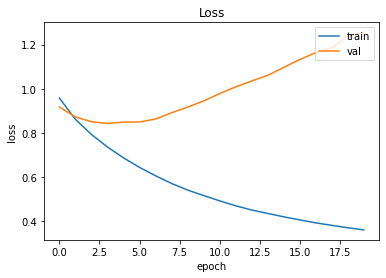

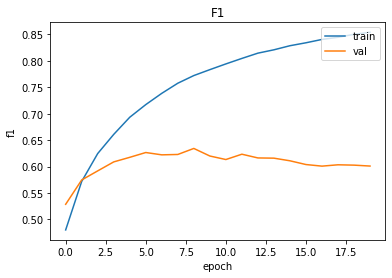

In [26]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(train_all_f1)
plt.plot(valid_all_f1)
plt.title('F1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [27]:
true, pred = test(model=model, iterator=test_loader, criterion=criterion)

Testing: 100%|██████████| 48/48 [00:00<00:00, 48.09it/s]


In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48      3972
           1       0.59      0.63      0.61      5937
           2       0.41      0.56      0.47      2375

    accuracy                           0.54     12284
   macro avg       0.53      0.53      0.52     12284
weighted avg       0.55      0.54      0.54     12284



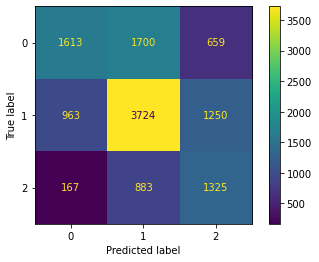

In [29]:
confusion_matrix = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

На обучающей выборке у нас довольно маленький лосс, однако на валидации совершенно иная картина, что говорит о переобучении нашей модели.
Чаще всего модель путает позитивные комментарии с негативными 
Как это можно было бы исправить:
            Взять побольше данных,
            Попробовать улучшить предобработку данных,
            Уменьшить количество параметров в модели,
            Попробовать другие гиперпараметры,
            Вообще поискать ошибки в коде (с большой вероятностью они есть)

Из плюсов: с 12 попытки удалось реализовать свою первую модель, хоть и плохонькую. Это уже победа.